# Nested Sampling test

In [1]:
import sys 
sys.path.insert(1, "..")
import torch
import numpy as np
import gpytorch
import matplotlib.pyplot as plt


In [2]:
def inverse_softplus(x):
    return x + torch.log(-torch.expm1(-x))




def my_softplus(x):
    return torch.log(-1 + torch.exp(x))

torch.nn.functional.softplus(my_softplus(torch.tensor(1)))


def reparameterize_model(model, theta):
    for model_param, sampled_param in zip(model.parameters(), theta):
        model_param.data = torch.full_like(model_param.data, float(sampled_param))

def reparameterize_and_mll(model, likelihood, theta, train_x, train_y):
    reparameterize_model(model, theta)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    mll_val = mll(model(train_x), train_y)
    return mll_val

def log_prior(mean, cov, params):
    # hack for constant noise
    prior = torch.distributions.MultivariateNormal(torch.tensor(mean), torch.tensor(cov))
    log_prob = prior.log_prob(torch.tensor(params[1]))
    return log_prob.squeeze(0)



In [3]:
train_x = torch.linspace(1, 500, 500)
train_y = torch.sin(train_x)
print(train_x)
print(train_y)

tensor([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
         13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
         25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,
         37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,
         49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
         61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
         73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,
         85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,
         97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107., 108.,
        109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
        121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
        133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143., 144.,
        145., 146., 147., 148., 149., 15

In [4]:
inverse_softplus(torch.tensor(0.1))

tensor(-2.2522)

In [5]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel() + gpytorch.kernels.RBFKernel()+ gpytorch.kernels.RBFKernel()+ gpytorch.kernels.RBFKernel()+ gpytorch.kernels.RBFKernel()+ gpytorch.kernels.RBFKernel()+ gpytorch.kernels.RBFKernel()+ gpytorch.kernels.RBFKernel()+ gpytorch.kernels.RBFKernel()+ gpytorch.kernels.RBFKernel()+ gpytorch.kernels.RBFKernel()+ gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-30))
model = ExactGPModel(train_x, train_y, likelihood)

In [6]:
#log_prior(prior_theta_mean, prior_theta_cov, [inverse_softplus(torch.tensor(0.01)), inverse_softplus(torch.tensor(1.))])
#torch.distributions.Normal(torch.tensor(-0.2122), torch.tensor(1.8895426067756804)).log_prob(torch.tensor(inverse_softplus(torch.tensor(1.))))
#torch.distributions.Normal(torch.tensor(0), torch.tensor(1.)).log_prob(torch.tensor(torch.tensor(5.)))

In [7]:
reparameterize_model(model, [inverse_softplus(torch.tensor(0.01)), torch.tensor(1.)])
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
mll(model(train_x), train_y)*2

tensor(-4.1745, grad_fn=<MulBackward0>)

In [8]:
model.covar_module.lengthscale

In [9]:
"""
There's a bug, what to test?
- Is the covariance matrix the same? (yes, except diagonal)
- Is the MLL the same?
- Is the posterior the same?
- Is the GP really parameterized the same?
- 
"""

"\nThere's a bug, what to test?\n- Is the covariance matrix the same? (yes, except diagonal)\n- Is the MLL the same?\n- Is the posterior the same?\n- Is the GP really parameterized the same?\n- \n"

In [10]:
ell = torch.tensor(2.0)
reparameterize_model(model, [inverse_softplus(torch.tensor(0.01)), ell])
#reparameterize_model(model, [-100, inverse_softplus(torch.tensor(5.))])
print(list(model.parameters()))
print(model.likelihood.noise)
print(model.covar_module.lengthscale)
log_prior_val = torch.distributions.Normal(torch.tensor(0), torch.tensor(1.)).log_prob(ell)
log_like = mll(model(train_x), train_y)*len(train_x)
log_like + log_prior_val

[Parameter containing:
tensor([-4.6002], requires_grad=True), Parameter containing:
tensor([[2.]], requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True)]
tensor([0.0100], grad_fn=<AddBackward0>)
None


tensor(-1045.1256, grad_fn=<AddBackward0>)

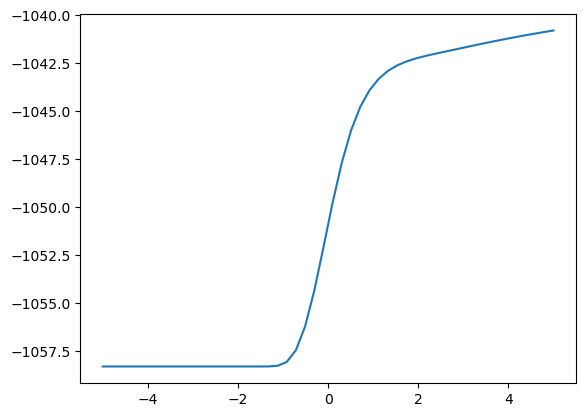

In [11]:
plot_range = torch.linspace(-5, 5, 50)
plt.plot(plot_range, [len(train_x)*reparameterize_and_mll(model, likelihood, [inverse_softplus(torch.tensor(0.01)), ell], train_x, train_y).detach().numpy() for ell in plot_range])


In [12]:
def log_posterior(model, theta):
    try:
        reparameterize_model(model, theta)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        mll(model(train_x), train_y)*len(train_x)
        log_prior_val = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([0., 0.]), torch.tensor([[1., 0.], [0., 1.]])).log_prob(theta)
        log_like = mll(model(train_x), train_y)*len(train_x)
    except Exception as E:
        print(theta)
        print(E)

    return (log_like + log_prior_val).detach()

In [13]:
import numpy as np
import dynesty
from dynesty import plotting as dyplot
import scipy
from metrics import prior_distribution




def reparameterize_model(model, theta):
    for model_param, sampled_param in zip(model.parameters(), theta):
        model_param.data = torch.full_like(model_param.data, float(sampled_param))

def reparameterize_and_mll(model, likelihood, theta, train_x, train_y):
    reparameterize_model(model, theta)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    try:
        mll_val = mll(model(train_x), train_y)
    except:
        mll_val = -np.inf
    return mll_val


def NestedSampling(model):

    prior_theta_mean, prior_theta_cov = prior_distribution(model)

    # Define the dimensionality of our problem.
    ndim = len(list(model.parameters()))

    def loglike(theta_i):
        with torch.no_grad():
            return (reparameterize_and_mll(model, model.likelihood, theta_i, model.train_inputs[0], model.train_targets)*len(*model.train_inputs))

    # Define our prior via the prior transform.
    def prior_transform(u):
        """Transforms the uniform random variables `u ~ Unif[0., 1.)`
        to the parameters of interest."""

        x = np.array(u)  # copy u

        # Bivariate Normal
        t = scipy.stats.norm.ppf(u)  # convert to standard normal
        Csqrt = np.linalg.cholesky(prior_theta_cov.numpy())  
        x = np.dot(Csqrt, t)  # correlate with appropriate covariance
        mu = prior_theta_mean.flatten().numpy()  # mean
        x += mu  # add mean
        return x

    # Trying out dynamic sampler
    dsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim, bound='multi')
    #dsampler.run_nested(maxiter=500)
    dsampler.run_nested(dlogz_init=0.01, nlive_init=500, nlive_batch=100)
    res = dsampler.results

    # Sample from our distribution.
    #sampler = dynesty.NestedSampler(loglike,
    #                                prior_transform,
    #                                ndim,
    #                                bound='multi',
    #                                sample='auto',
    #                                nlive=100,
    #                                first_update={"min_eff": 3.0})
    #sampler.run_nested(dlogz=0.01)
    #res = sampler.results

    return res

In [14]:
res = NestedSampling(model)#, store_full=True, res_file_name=f"NANI.pkl", print_progress=True, maxcall = 3000000)

0it [00:00, ?it/s]/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/dynesty/dynamicsampler.py:447: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
1019it [01:15,  4.73it/s, batch: 0 | bound: 0 | nc: 11 | ncall: 3411 | eff(%): 26.055 | loglstar:   -inf < -1025.680 <    inf | logz: -1030.546 +/-  0.089 | dlogz: 130.284 >  0.010]

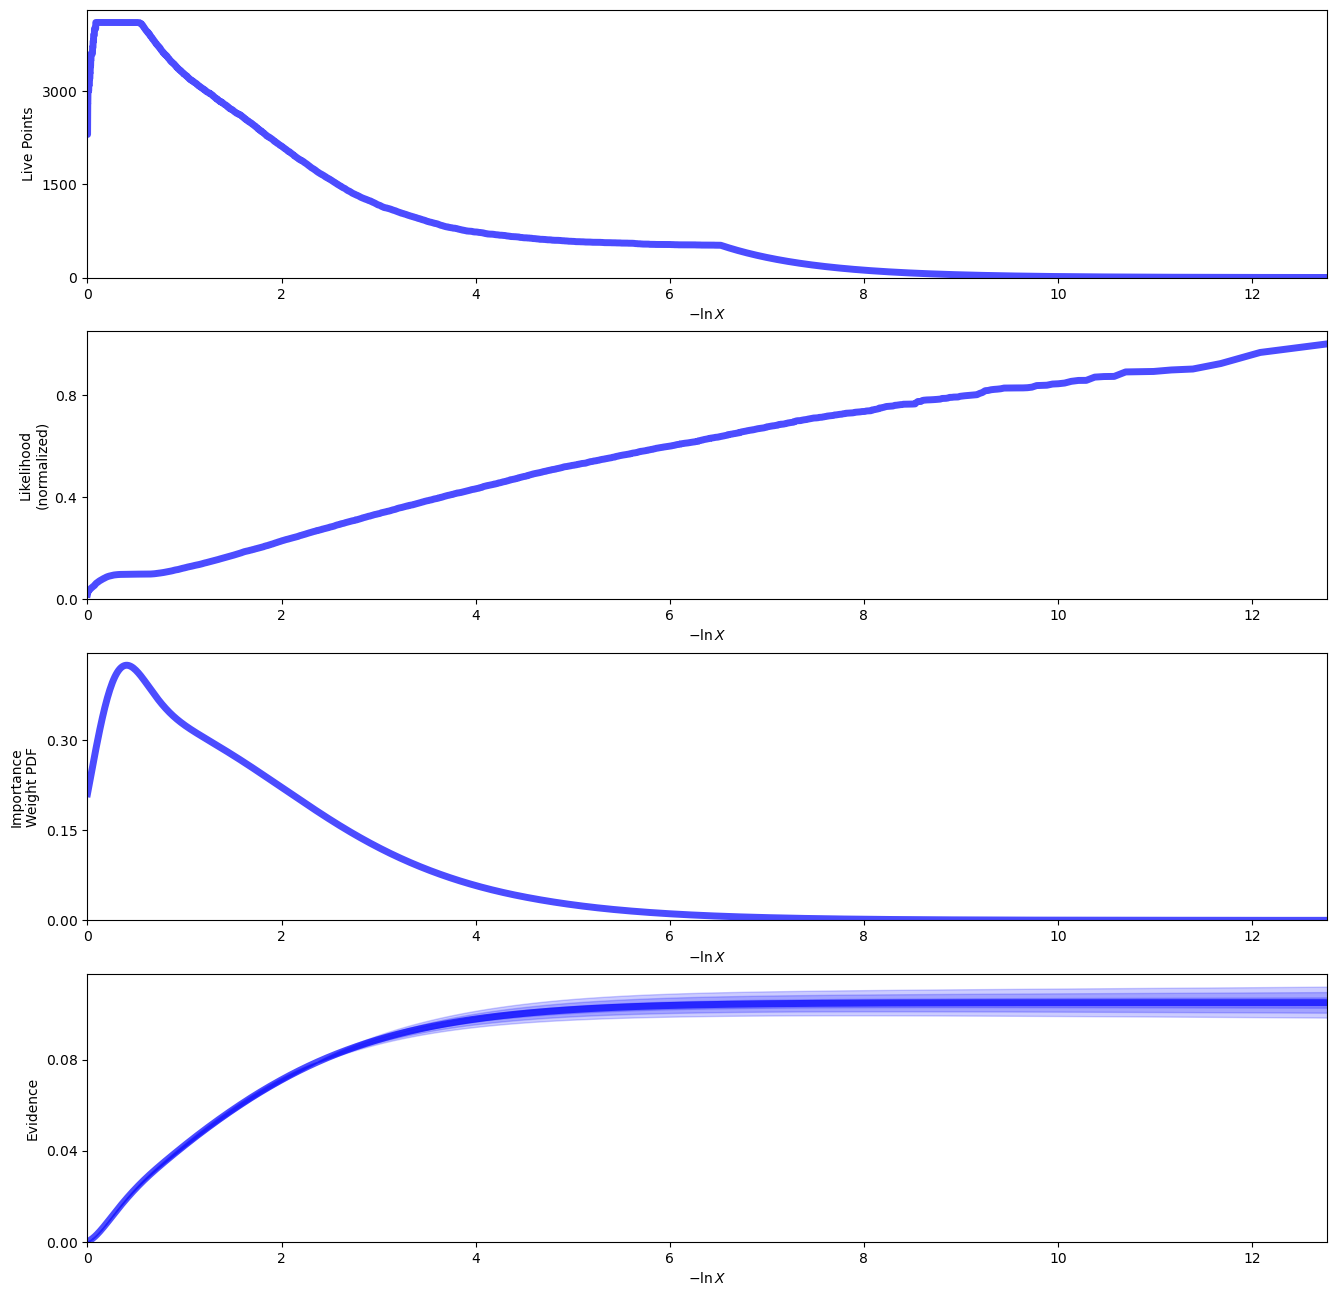

In [ ]:
# TODO Bei jedem Call die Bilder erstellen lassen und wegspeichern
fig, axes = dyplot.runplot(res)#, lnz_truth=lnz_truth)

In [ ]:
res.summary()

Summary
niter: 11041
ncall: 34570
eff(%): 31.893
logz: -2.254 +/-  0.022


['niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_batch', 'samples_it', 'samples_u', 'samples_n', 'logwt', 'logl', 'logvol', 'logz', 'batch_nlive', 'batch_bounds', 'blob', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale']


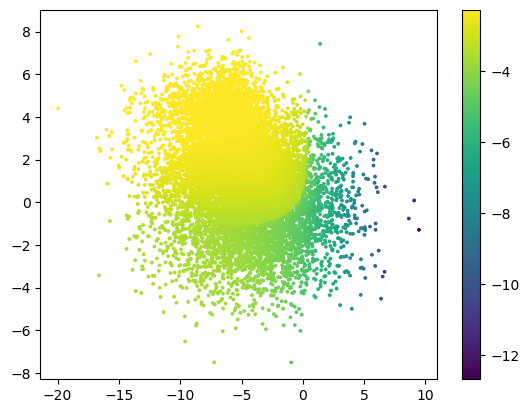

In [ ]:
print(res.keys())
# noise/lengthscale
plt.scatter(res.samples[:,0], res.samples[:,1], c=res.logz, s=3)
plt.colorbar()